Folders ready: ../data/processed ../figures
Years to sample: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Sampling up to 5000 studies per year.

Fetching sampled trials for registry completeness & results timeliness...

Year 2015 done. Sampled 5000 trials (cumulative 5000).
Year 2016 done. Sampled 5000 trials (cumulative 10000).
Year 2017 done. Sampled 5000 trials (cumulative 15000).
Year 2018 done. Sampled 5000 trials (cumulative 20000).
Year 2019 done. Sampled 5000 trials (cumulative 25000).
Year 2020 done. Sampled 5000 trials (cumulative 30000).
Year 2021 done. Sampled 5000 trials (cumulative 35000).
Year 2022 done. Sampled 5000 trials (cumulative 40000).
Year 2023 done. Sampled 5000 trials (cumulative 45000).
Year 2024 done. Sampled 5000 trials (cumulative 50000).
Year 2025 done. Sampled 5000 trials (cumulative 55000).

Sample size by year:
2015    5000
2016    5000
2017    5000
2018    5000
2019    5000
2020    5000
2021    5000
2022    5000
2023    5000
2024

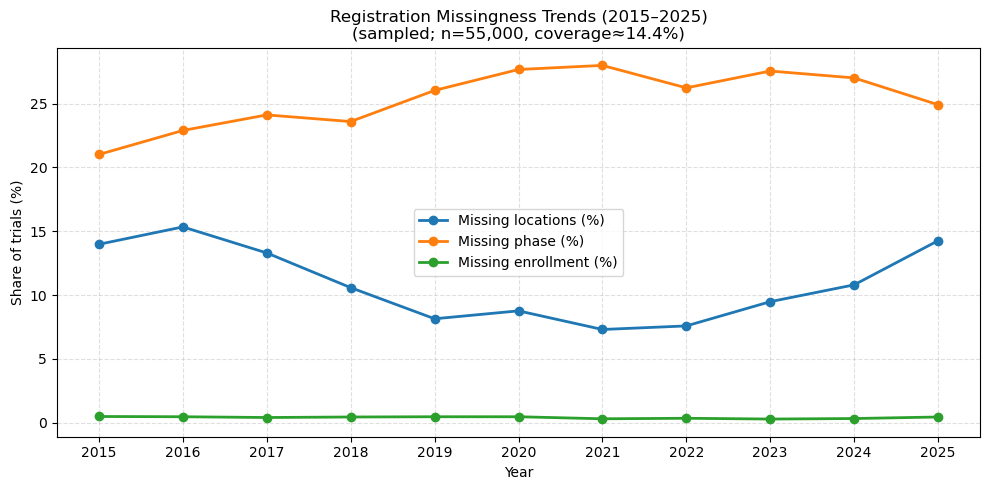

Saved figure: ../figures/module5_missingness_trends_2015_2025.png

Saved results-timeliness table to: ../data/processed/module5_results_within_X_years_by_cohort.csv


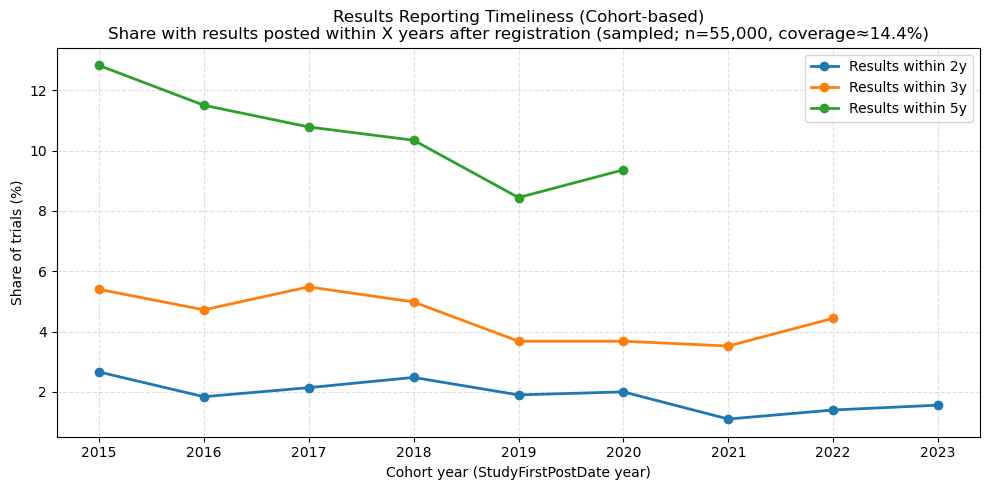

Saved figure: ../figures/module5_results_within_X_years_cohort_trends.png

Interpretation notes (Module 5):
1) Missingness trends reflect *registry field availability* (presence-based).
   Rising missing locations can mechanically lower observed multi-center / multi-country rates.
2) Raw 'hasResults by registration year' is biased downward for recent cohorts due to limited follow-up time.
   The cohort-based 'results within X years' metric is more stable because it right-censors recent cohorts.
3) Enrollment is a numeric participant count. If EnrollmentType is present, it can be 'ESTIMATED' or 'ACTUAL'.
4) As-of date used for right-censoring: 2025-12-31

Done.


In [4]:
"""
Module 5 — Registration Completeness & Results Reporting Timeliness (2015–2025, sampled)

Goal
-----
Using a sampled subset of newly registered clinical trials from ClinicalTrials.gov (2015–2025),
this module focuses on *data quality and transparency* signals that are visible in the registry:

A) Registration completeness (missingness) trends by year:
   - Missing locations (%)
   - Missing phase (%)
   - Missing enrollment (%)

B) Results reporting timeliness (a more stable metric than raw hasResults by year):
   - For each registration-year cohort, compute the share of trials that posted results
     within X years after first posting date (e.g., X=2,3,5).
   - Apply right-censoring: only include cohorts that have had at least X years of follow-up.

Notes
-----
- Presence-based: we rely on fields present in the registry API response.
- Sampling: per year, up to MAX_PAGES * PAGE_SIZE studies (e.g., ~5000).
- 2025 is included in missingness trends, but results-within-X analysis is right-censored.
"""

import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Paths and base settings
# -------------------------------------------------------------------
BASE_URL = "https://clinicaltrials.gov/api/v2/studies"
PROCESSED_DIR = "../data/processed"
FIG_DIR = "../figures"
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

MODULE1_TOTALS_PATH = os.path.join(PROCESSED_DIR, "global_trials_totalcount_by_year_2015_2025.csv")

YEARS = list(range(2015, 2026))  # 2015..2025 inclusive
PAGE_SIZE = 500
MAX_PAGES = 10  # ~5000 studies/year

print("Folders ready:", PROCESSED_DIR, FIG_DIR)
print("Years to sample:", YEARS)
print(f"Sampling up to {MAX_PAGES * PAGE_SIZE} studies per year.\n")


# -------------------------------------------------------------------
# Helpers
# -------------------------------------------------------------------
def safe_get(d, *keys, default=None):
    """Safely navigate nested dicts. Returns default if any key is missing."""
    cur = d
    for k in keys:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur

def parse_date(s):
    """Parse YYYY-MM-DD (or None) to pandas Timestamp."""
    if not s:
        return pd.NaT
    try:
        return pd.to_datetime(s, errors="coerce")
    except Exception:
        return pd.NaT


# -------------------------------------------------------------------
# Step 1: Fetch sampled trials (2015–2025) and extract registry fields
# -------------------------------------------------------------------
records = []
print("Fetching sampled trials for registry completeness & results timeliness...\n")

for year in YEARS:
    start, end = f"{year}-01-01", f"{year}-12-31"
    page_token = None
    page_count = 0
    year_before = len(records)

    while page_count < MAX_PAGES:
        params = {
            "query.term": f"AREA[StudyFirstPostDate]RANGE[{start},{end}]",
            "pageSize": PAGE_SIZE,
            "format": "json",
        }
        if page_token:
            params["pageToken"] = page_token

        r = requests.get(BASE_URL, params=params, timeout=60)
        if r.status_code != 200:
            print(f"Year {year} HTTP error:", r.status_code)
            print(r.text[:300])
            break

        data = r.json()
        studies = data.get("studies", [])
        if not studies:
            break

        for s in studies:
            protocol = s.get("protocolSection", {})

            # ---- Dates (cohort anchor + results date if available) ----
            first_post = safe_get(protocol, "statusModule", "studyFirstPostDateStruct", "date")
            results_post = safe_get(protocol, "statusModule", "resultsFirstPostDateStruct", "date")

            first_post_dt = parse_date(first_post)
            results_post_dt = parse_date(results_post)

            # ---- hasResults flag (often top-level) ----
            has_results = s.get("hasResults", None)
            if has_results is None:
                # fallback: infer from results date presence
                has_results = bool(pd.notna(results_post_dt))

            # ---- Phase ----
            phases = safe_get(protocol, "designModule", "phases", default=[])
            if phases is None:
                phases = []
            phase_missing = (len(phases) == 0)

            # ---- Enrollment ----
            enroll_info = safe_get(protocol, "designModule", "enrollmentInfo", default={})
            enroll_count = None
            enroll_type = None
            if isinstance(enroll_info, dict):
                enroll_count = enroll_info.get("count", None)
                enroll_type = enroll_info.get("type", None)
            enrollment_missing = (enroll_count is None)

            # ---- Locations ----
            locs = safe_get(protocol, "contactsLocationsModule", "locations", default=[])
            if locs is None:
                locs = []
            locations_missing = (len(locs) == 0)

            # Optional: num locations / num countries if you want later
            num_locations = len(locs)
            countries = set()
            for loc in locs:
                c = None
                if isinstance(loc, dict):
                    c = loc.get("locationCountry", None)
                if c:
                    countries.add(c)
            num_countries = len(countries)

            records.append({
                "Year": year,
                "StudyFirstPostDate": first_post_dt,
                "ResultsFirstPostDate": results_post_dt,
                "HasResults": bool(has_results),
                "PhaseMissing": bool(phase_missing),
                "EnrollmentMissing": bool(enrollment_missing),
                "LocationsMissing": bool(locations_missing),
                "EnrollmentCount": enroll_count,
                "EnrollmentType": enroll_type,
                "NumLocations": num_locations,
                "NumCountries": num_countries,
            })

        page_token = data.get("nextPageToken")
        page_count += 1
        if not page_token:
            break

    year_added = len(records) - year_before
    print(f"Year {year} done. Sampled {year_added} trials (cumulative {len(records)}).")

df = pd.DataFrame(records)
print("\nSample size by year:")
print(df["Year"].value_counts().sort_index())

trial_level_path = os.path.join(PROCESSED_DIR, "module5_registry_quality_trial_level_sample_2015_2025.csv")
df.to_csv(trial_level_path, index=False)
print("\nSaved trial-level sample to:", trial_level_path)


# -------------------------------------------------------------------
# Step 2: Compute sample coverage (%) vs Module 1 totals (if available)
# -------------------------------------------------------------------
total_sampled = len(df)

coverage_pct = None
total_population = None
if os.path.exists(MODULE1_TOTALS_PATH):
    df_tot = pd.read_csv(MODULE1_TOTALS_PATH)
    df_tot_15_25 = df_tot.query("Year >= 2015 & Year <= 2025").copy()
    total_population = int(df_tot_15_25["TrialCount"].sum())
    coverage_pct = 100.0 * total_sampled / total_population
    print(f"\nSampled trials (Module 5): {total_sampled:,}")
    print(f"Total trials 2015–2025 (Module 1): {total_population:,}")
    print(f"Coverage ≈ {coverage_pct:.2f}% of all trials")
else:
    print(f"\nWARNING: Module 1 totals file not found at: {MODULE1_TOTALS_PATH}")
    print("Coverage will be reported as NA.\n")


# -------------------------------------------------------------------
# Step 3: Missingness trends by year (locations / phase / enrollment)
# -------------------------------------------------------------------
missing_by_year = (
    df.groupby("Year")[["LocationsMissing", "PhaseMissing", "EnrollmentMissing"]]
      .mean()
      .mul(100)
      .rename(columns={
          "LocationsMissing": "MissingLocations_pct",
          "PhaseMissing": "MissingPhase_pct",
          "EnrollmentMissing": "MissingEnrollment_pct",
      })
      .reset_index()
)

missing_path = os.path.join(PROCESSED_DIR, "module5_missingness_by_year_2015_2025_sample.csv")
missing_by_year.to_csv(missing_path, index=False)
print("\nSaved missingness table to:", missing_path)

plt.figure(figsize=(10, 5))
plt.plot(missing_by_year["Year"], missing_by_year["MissingLocations_pct"], marker="o", linewidth=2, label="Missing locations (%)")
plt.plot(missing_by_year["Year"], missing_by_year["MissingPhase_pct"], marker="o", linewidth=2, label="Missing phase (%)")
plt.plot(missing_by_year["Year"], missing_by_year["MissingEnrollment_pct"], marker="o", linewidth=2, label="Missing enrollment (%)")

title_cov = "NA" if coverage_pct is None else f"{coverage_pct:.1f}%"
plt.title(
    "Registration Missingness Trends (2015–2025)\n"
    f"(sampled; n={total_sampled:,}, coverage≈{title_cov})"
)
plt.xlabel("Year")
plt.ylabel("Share of trials (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xticks(missing_by_year["Year"], [str(y) for y in missing_by_year["Year"]], rotation=0)
plt.legend()
plt.tight_layout()

fig1_path = os.path.join(FIG_DIR, "module5_missingness_trends_2015_2025.png")
plt.savefig(fig1_path, dpi=300)
plt.show()
print("Saved figure:", fig1_path)


# -------------------------------------------------------------------
# Step 4: Results reporting timeliness (within X years, cohort-based)
#         This avoids the "new trials haven't had time to post results" bias.
# -------------------------------------------------------------------
def cohort_results_within_x_years(df_in, x_years=3, asof_date=None):
    """
    Returns cohort-level percent of trials with results posted within X years
    after StudyFirstPostDate.

    Right-censoring:
      only include trials with StudyFirstPostDate <= (asof_date - X years),
      so every included trial had at least X years of follow-up time.

    Required columns:
      - StudyFirstPostDate (datetime)
      - ResultsFirstPostDate (datetime; NaT allowed)
    """
    d = df_in.copy()
    d = d[pd.notna(d["StudyFirstPostDate"])].copy()

    if asof_date is None:
        asof_date = pd.Timestamp.today().normalize()

    cutoff = asof_date - pd.DateOffset(years=x_years)
    d = d[d["StudyFirstPostDate"] <= cutoff].copy()

    if d.empty:
        return pd.DataFrame(columns=["CohortYear", "PctWithinX", "N"])

    deadline = d["StudyFirstPostDate"] + pd.DateOffset(years=x_years)
    d["WithinX"] = pd.notna(d["ResultsFirstPostDate"]) & (d["ResultsFirstPostDate"] <= deadline)

    d["CohortYear"] = d["StudyFirstPostDate"].dt.year

    out = (
        d.groupby("CohortYear")["WithinX"]
         .agg(["mean", "size"])
         .reset_index()
         .rename(columns={"mean": "PctWithinX", "size": "N"})
    )
    out["PctWithinX"] = out["PctWithinX"] * 100.0
    return out.sort_values("CohortYear")


# Choose multiple X for sensitivity (you can keep only one if you prefer)
X_LIST = [2, 3, 5]
asof_date = pd.Timestamp.today().normalize()  # analysis "as-of" date

results_tables = []
plt.figure(figsize=(10, 5))

for x in X_LIST:
    tab = cohort_results_within_x_years(df, x_years=x, asof_date=asof_date)
    tab["X_years"] = x
    results_tables.append(tab)

    if not tab.empty:
        plt.plot(tab["CohortYear"], tab["PctWithinX"], marker="o", linewidth=2, label=f"Results within {x}y")

results_within_path = os.path.join(PROCESSED_DIR, "module5_results_within_X_years_by_cohort.csv")
pd.concat(results_tables, ignore_index=True).to_csv(results_within_path, index=False)
print("\nSaved results-timeliness table to:", results_within_path)

title_cov = "NA" if coverage_pct is None else f"{coverage_pct:.1f}%"
plt.title(
    "Results Reporting Timeliness (Cohort-based)\n"
    f"Share with results posted within X years after registration "
    f"(sampled; n={total_sampled:,}, coverage≈{title_cov})"
)
plt.xlabel("Cohort year (StudyFirstPostDate year)")
plt.ylabel("Share of trials (%)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()

fig2_path = os.path.join(FIG_DIR, "module5_results_within_X_years_cohort_trends.png")
plt.savefig(fig2_path, dpi=300)
plt.show()
print("Saved figure:", fig2_path)


# -------------------------------------------------------------------
# Step 5: Quick interpretation notes (printed)
# -------------------------------------------------------------------
print("\nInterpretation notes (Module 5):")
print("1) Missingness trends reflect *registry field availability* (presence-based).")
print("   Rising missing locations can mechanically lower observed multi-center / multi-country rates.")
print("2) Raw 'hasResults by registration year' is biased downward for recent cohorts due to limited follow-up time.")
print("   The cohort-based 'results within X years' metric is more stable because it right-censors recent cohorts.")
print("3) Enrollment is a numeric participant count. If EnrollmentType is present, it can be 'ESTIMATED' or 'ACTUAL'.")
print(f"4) As-of date used for right-censoring: {asof_date.date()}")
print("\nDone.")

